In [29]:
#import libraries
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
pd.options.mode.chained_assignment = None 
sns.set(font='Times New Roman')
sns.set(font_scale=1.5)
import re
import csv
import os

In [30]:
df_weekly_sum = pd.read_csv('dpgr_who_continets.csv')
df_weekly_sum.head()

,Variant,Date,Location,Freq
0,Alpha,2019-12-30/2020-01-05,Africa,1
1,Alpha,2019-12-30/2020-01-05,Asia,8
2,Alpha,2019-12-30/2020-01-05,Europe,629
3,Alpha,2019-12-30/2020-01-05,North America,9
4,Alpha,2020-02-03/2020-02-09,Europe,1


### A modified distance matrix for selecting the variants to compare

In [31]:
#clades contains all GISAID clades, VOC contains GISAID clades containing VOCs
#change clade input to whichever you want to analyze
clades = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron','Epsilon','Lambda','Iota','Kappa','Mu','Eta','Zeta','Theta']
# VOC = ['Delta', 'Omicron']
VOC = ['Omicron', 'Delta']
# VOC = ['Alpha', 'Beta', 'Gamma', 'Delta', 'Omicron']

clade_input = VOC    ####

# # #function to generate distance matrix based on quarter, year, and continent
# def create_distance_matrix(df,quarter_continent, variant_choice_set):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     clade_list = [variant for variant in clade_list if variant in variant_choice_set]
#     distance_matrix = pd.DataFrame(index = clade_list)
#     distance_matrix[clade_list] = np.nan
#     #fill in distance matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 distance_matrix.loc[i,j] = 0
#             else:
#                 distance_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 distance_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     return distance_matrix

# #distance matrix where you can select which variants to compare 
# def create_distance_matrix(df, quarter_continent, variant_choice_set):
#     clade_list = set()
#     for variant in df['Variant']:
#         clades = variant.split(' vs ')
#         clade_list.update(clades)
# #         print(clade_list)

    
#     clade_list = sorted(clade_list)
#     clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
#     distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
#     distance_matrix.fillna(0, inplace=True)

#     for i in clade_list:
#         for j in clade_list:
#             if i != j:
#                 variant_1 = f"{i} vs {j}"
#                 variant_2 = f"{j} vs {i}"
#                 slope_1 = df.loc[df['Variant'] == variant_1, 'Slope']
#                 slope_2 = df.loc[df['Variant'] == variant_2, 'Slope']
#                 slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
#                 distance_matrix.loc[i, j] = abs(slope)

#     return distance_matrix
# #     print(distance_matrix)

#updated distance matrix which resolves the symmetricity issue
def create_distance_matrix(df, quarter_continent, variant_choice_set):
    clade_list = set()
    for variant in df['Variant']:
        clades = variant.split(' vs ')
        clade_list.update(clades)
#         print(clade_list)

    
    clade_list = sorted(clade_list)
#     print(clade_list)
    clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
#     clade_list = clade_list.reverse()
    print(clade_list)
    distance_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
    distance_matrix.fillna(0, inplace=True)

    for i in clade_list:
        for j in clade_list:
            if i != j:
                variant_1 = f"{i} vs {j}"
                variant_2 = f"{j} vs {i}"
                slope_1 = df.loc[df['Variant'] == variant_1, 'Slope']
                slope_2 = df.loc[df['Variant'] == variant_2, 'Slope']
                slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
                distance_matrix.loc[i, j] = abs(slope)
                distance_matrix.loc[j, i] = abs(slope)  # Add this line to ensure symmetry

    return distance_matrix
#     print(distance_matrix)


# # #function to generate difference matrix based on quarter, year, and continent
# def create_difference_matrix(df,quarter_continent, variant_choice_set):
#     tmp = df['Variant'].str.split('vs', expand=True)
#     clade_list = tmp[0].unique()
#     clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
#     difference_matrix = pd.DataFrame(index = clade_list)
#     difference_matrix[clade_list] = np.nan
#     #fill in difference matrix
#     for i in clade_list:
#         for j in clade_list:
#             if i == j:
#                 difference_matrix.loc[i,j] = 0
#             else:
#                 difference_matrix.loc[i,j] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#                 difference_matrix.loc[j,i] = (abs((df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                         quarter_continent].iloc[0] + 
#                                             df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j), 
#                                                    quarter_continent].iloc[0])/2))
#     #if row_vs_col is a negative value, make it negative in difference matrix
#     for i,v in difference_matrix.iterrows():
#         for j in difference_matrix:
#             if i != j:
#                 if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
#                     difference_matrix.loc[i,j] *= -1
#     return difference_matrix



#difference matrix where you can select which variants to compare 
def create_difference_matrix(df, quarter_continent, variant_choice_set):
    clade_list = set()
    for variant in df['Variant']:
        clades = variant.split(' vs ')
        clade_list.update(clades)
#         print(clade_list)

    
    clade_list = sorted(clade_list)
#     print(clade_list)
    clade_list = [variant for variant in clade_list if variant in variant_choice_set] #
#     clade_list = clade_list.reverse()
    difference_matrix = pd.DataFrame(index=clade_list, columns=clade_list)
    
    difference_matrix.fillna(0, inplace=True)

    for i in clade_list:
        for j in clade_list:
            if i != j:
                variant_1 = f"{i} vs {j}"
                variant_2 = f"{j} vs {i}"
                slope_1 = df.loc[df['Variant'] == variant_1, 'Slope']
                slope_2 = df.loc[df['Variant'] == variant_2, 'Slope']
                slope = slope_1.iloc[0] if not slope_1.empty else slope_2.iloc[0]
                difference_matrix.loc[i, j] = abs(slope)
                difference_matrix.loc[j, i] = abs(slope)  # Add this line to ensure symmetry

    #if row_vs_col is a negative value, make it negative in difference matrix
    for i,v in difference_matrix.iterrows():
        for j in difference_matrix:
            if i != j:
                if (df.loc[df['Variant'] == '{a} vs {b}'.format(a=i,b=j),quarter_continent].iloc[0]) < 0:
                    difference_matrix.loc[i,j] *= -1
    return difference_matrix

#function to calculate the log transformed ratio of two clades
def transform_ratio(clade_1, clade_2):
    return np.log10(clade_1/clade_2)

def time_frame(df, start_date, end_date):  #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    dataframe.iloc[:,2:] = dataframe.iloc[:,2:].cumsum()
    for i in dataframe.columns.tolist():
        if dataframe[i].isnull().all():
            dataframe = dataframe.drop(i, axis=1)
    return dataframe


# def time_frame_no_cumsum(df,time_window):
#     dataframe = df.loc[df['Collection date'].isin(time_window)]
#     return dataframe

def time_frame_no_cumsum(df,start_date, end_date): #updated
    time_window = pd.date_range(start=start_date, end=end_date).strftime('%Y-%m').unique().tolist()
    print(time_window)
    dataframe = df.loc[df['Collection date'].isin(time_window)]
    return dataframe

#function returns slope of clade advantage plots
def slope_calc(day, pairwise_fitness):
#     print(day)
#     print(pairwise_fitness)
    par = np.polyfit(day, pairwise_fitness, 1, full = True)
    slope= par[0][0]
    return slope

def clade_comparisons(df):
    clade_list = [i for i in clade_input if i in df.columns.tolist()]

    df['date_ordinal'] = pd.to_datetime(df['Date']).apply(lambda date: date.toordinal())
    df['days'] = df['date_ordinal'] - 737425
    #calculate log ratio for each clade comparison
    for i in clade_list:
        for j in clade_list:
            if i != j:
                df['{a} vs {b}'.format(a=i,b=j)] = df.apply(lambda row : 
                                                                        transform_ratio(row['{a}'.format(a=i)],
                                                                                        row['{b}'.format(b=j)]),
                                                                                        axis = 1)
    clade_list.append('date_ordinal')
    df = df.drop(clade_list, axis=1)
    return df

In [32]:
# This function finds the distance matrix among all the clades 

def automation_mine(country, dataset, start, end, variant_choice_set):
    
    df_weekly = dataset[dataset['Location'] == country]
    

    #pivot dataframe so that index is date and columns are clades
    df_weekly = df_weekly.pivot(index = 'Date', columns = 'Variant', values = 'Freq')
    df_weekly = df_weekly.reset_index()
    

    df_weekly['Collection date'] = np.random.randint(1,6,df_weekly.shape[0])

    #split date column so we can retrieve month and year
    tmp = df_weekly['Date'].str.rsplit('-',n=3, expand = True)
    tmp.columns = ['0','1','2','3']

    #collection date column contains month and year of each week 
    df_weekly['Collection date'] = tmp['0']
    cols = df_weekly.columns.tolist()
    cols = cols[0:1] + cols[-1:] + cols[1:-1]
    df_weekly = df_weekly[cols]
#     print(f"df_weekly : \n {df_weekly.head}")
#     print(f"df_weekly : \n {df_weekly.columns}")
           
    #specify time frame to analyze
    df_sum = time_frame(df_weekly, start, end)
    # df_sum.to_csv(country+"df_sum"+r'.csv')
#     print(df_sum)
    #calculate log comparisons at each week
    df_ = clade_comparisons(df_sum)
#     print(df_)
    # df_.to_csv(country+'_clade_comparison')
    df_['days'] -= df_['days'].iloc[0]
#     print(f"df_ :\n {df_}")
#     print(f"df_ :\n {df_.columns}")

    #Make the combinations of the variant choice set
    combinations = []

    # Append 'Omicron vs Delta'
    combination1 = ' vs '.join(variant_choice_set)
    combinations.append(combination1)

    # Append 'Delta vs Omicron'
    combination2 = ' vs '.join(sorted(list(variant_choice_set), reverse=True))
    combinations.append(combination2)
    

    #calculate slopes, have to disregard nans
    df_slopes = pd.DataFrame()
    cols = df_.columns.to_list()
#     print(f"df_ columns : {cols}")
    df_slopes['Variant'] = cols[3:]
#     print(f"df_slopes:\n {df_slopes}")
    slopes = []
    for i,v in enumerate(df_.iloc[:,3:]):
#         tmp = df_[~df_.iloc[:,i+3].isnull()] ##issue (it chooses columns using the index)
        tmp = df_[df_.loc[:, df_.columns.isin(combinations)].notnull().any(axis=1)] #it chooses the columns that are given in the variant_choice set
        tmp['pseudo_time'] = np.array(range(0, tmp.shape[0] ))*7
#         print(f"tmp :\n {tmp}")
        slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp.iloc[0:len(tmp),i+3]))
#         slopes.append(slope_calc(tmp.iloc[0:len(tmp),len(tmp.columns) - 1], tmp[v])) 
        #print(len(slopes))
#         print(df_slopes)
#     print(f"tmp :\n {tmp}")
#     print(f"Slopes: {slopes}")
    df_slopes['Slope'] = slopes
#     print(df_slopes)
    df_slopes = pd.DataFrame(df_slopes)   #changed
    # df_slopes.to_csv(country+"_slope_WHO"+r'.csv')
#     print(f"Slope :\n {df_slopes}")
    
#     dist_mat = create_distance_matrix(df_slopes,'Slope')
#     # dist_mat.to_csv(country+"_dist_mat_WHO"+r'.csv')
#     print(f"distance matrix :\n {dist_mat}")

    #define the file path
    file_path = f'/scr/mjpantho/Pantho_differential_fitness/Distance_matrix_who/{country + "_" + start + "_" + end + "_dist_mat_who_labels"}.csv'

    dist_mat = create_distance_matrix(df_slopes,'Slope', variant_choice_set)
#     dist_mat.fillna(0, inplace = True)
#     dist_mat.to_csv(file_path, index=True)
    print(f"Diatance matrix: \n {dist_mat}")
    
    dif_mat = create_difference_matrix(df_slopes,'Slope', variant_choice_set)
    # dif_mat.to_csv(country+"_dif_mat_WHO"+r'.csv')
    print(f"difference matrix :\n {dif_mat}")
#     dif_mat.fillna(0, inplace = True)
    
    #Plot distance matrix as clustermap
    sns.set(rc={'figure.figsize': (2, 2)}, font_scale=1.2)  # Adjust the figsize as per your preference

    #create distance array from distance matrix
    distance_array = ssd.squareform(dist_mat) 

    #create linkage object
    distance_linkage = hierarchy.linkage(distance_array)
#     print(distance_linkage)
#     print(distance_array.shape)
#     print(dist_mat.shape)

    # Display clustermap
    g = sns.clustermap(dif_mat, row_linkage=distance_linkage, col_linkage=distance_linkage,
                   cmap='coolwarm', vmin=-.023, vmax=0.023, cbar_pos=(0.971, 0.079, .05, 0.74 * (4 / 4)),figsize=(4, 4))
    #add title to the heatmap
    variant_choice_set = list(variant_choice_set)
    first_element = variant_choice_set[1]
    second_element = variant_choice_set[0]
#     print(variant_choice_set)
    g.fig.suptitle(f'{first_element} vs {second_element}\nTime Window: ({start}) - ({end})\nLocation: {country}', fontsize = 8.5, y=1.05)

    # Specify the directory path
    directory = "/scr/mjpantho/Pantho_differential_fitness/omicron_vs_delta_heatmaps_continents/"

    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the figure to the specified directory with DPI set to 300
    filename = os.path.join(directory, country + "_Omicron_vs_delta_heatmaps_continents.png")
    g.savefig(filename, dpi=300, bbox_inches="tight")

    # Return the clustermap
    return g


['2022-03', '2022-04', '2022-05']
['Delta', 'Omicron']
Diatance matrix: 
            Delta  Omicron
Delta    0.00000  0.00801
Omicron  0.00801  0.00000
difference matrix :
            Delta  Omicron
Delta    0.00000 -0.00801
Omicron  0.00801  0.00000


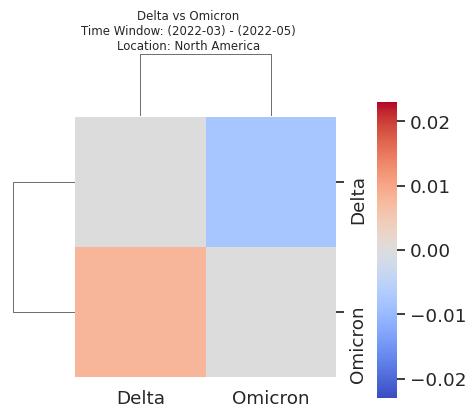

In [33]:
# #automation function finds the diatance matrix
automation_mine('North America', df_weekly_sum, start = '2022-03', end = '2022-05', variant_choice_set= {'Omicron', 'Delta'})

['2021-12']
['Delta', 'Omicron']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.056064
Omicron  0.056064  0.000000
difference matrix :
             Delta   Omicron
Delta    0.000000 -0.056064
Omicron  0.056064  0.000000


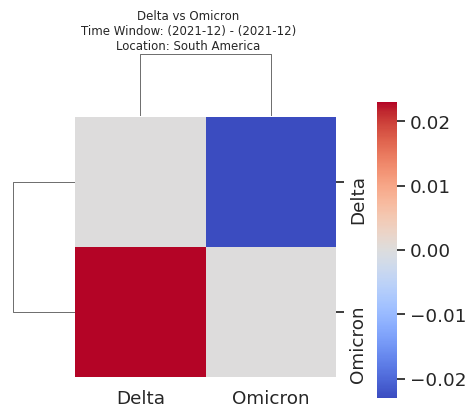

In [34]:
# #automation function finds the diatance matrix
automation_mine('South America', df_weekly_sum, start = '2021-12', end = '2021-12', variant_choice_set= {'Omicron', 'Delta'})

['2022-02', '2022-03']
['Delta', 'Omicron']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.009437
Omicron  0.009437  0.000000
difference matrix :
             Delta   Omicron
Delta    0.000000 -0.009437
Omicron  0.009437  0.000000


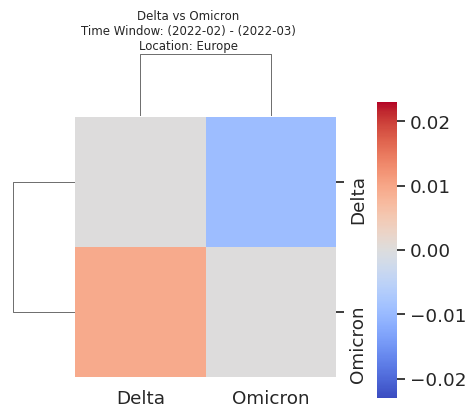

In [35]:
# #automation function finds the diatance matrix
automation_mine('Europe', df_weekly_sum, start = '2022-02', end = '2022-03', variant_choice_set= {'Omicron', 'Delta'})

['2022-01', '2022-02', '2022-03', '2022-04']
['Delta', 'Omicron']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.006345
Omicron  0.006345  0.000000
difference matrix :
             Delta   Omicron
Delta    0.000000 -0.006345
Omicron  0.006345  0.000000


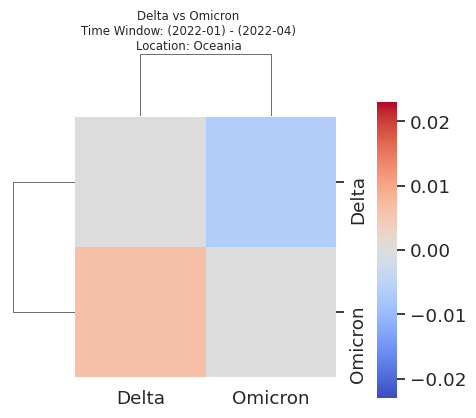

In [36]:
# #automation function finds the diatance matrix
automation_mine('Oceania', df_weekly_sum, start = '2022-01', end = '2022-04', variant_choice_set= {'Omicron', 'Delta'})

['2021-12']
['Delta', 'Omicron']
Diatance matrix: 
          Delta  Omicron
Delta    0.000    0.058
Omicron  0.058    0.000
difference matrix :
          Delta  Omicron
Delta    0.000   -0.058
Omicron  0.058    0.000


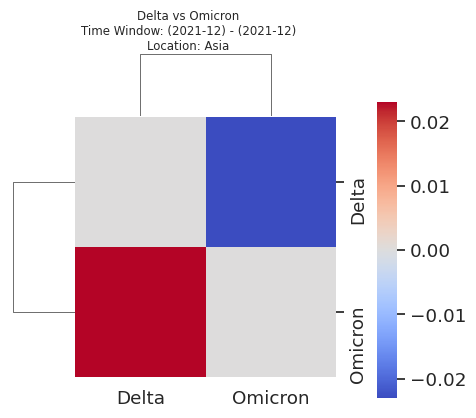

In [37]:
# #automation function finds the diatance matrix
automation_mine('Asia', df_weekly_sum, start = '2021-12', end = '2021-12', variant_choice_set= {'Omicron', 'Delta'})

['2021-11', '2021-12']
['Delta', 'Omicron']
Diatance matrix: 
             Delta   Omicron
Delta    0.000000  0.034965
Omicron  0.034965  0.000000
difference matrix :
             Delta   Omicron
Delta    0.000000 -0.034965
Omicron  0.034965  0.000000


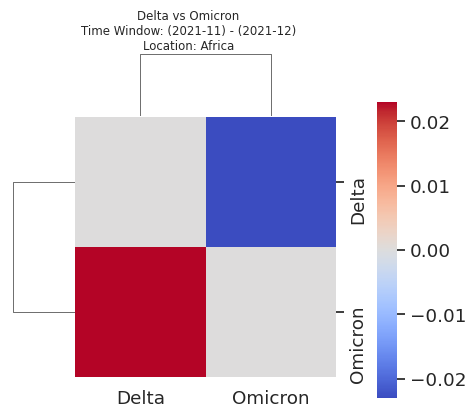

In [38]:
# #automation function finds the diatance matrix
automation_mine('Africa', df_weekly_sum, start = '2021-11', end = '2021-12', variant_choice_set= {'Omicron', 'Delta'})